In [1]:
import datetime  # 导入 datetime 模块，用于处理日期和时间相关的操作
import glob  # 导入 glob 模块，用于查找符合特定规则的文件路径
import math  # 导入 math 模块，提供数学计算功能（如平方根、对数等）
import os  # 导入 os 模块，用于与操作系统交互（如文件路径操作）

from pathlib import Path  # 导入 Path 类，用于更方便地处理文件路径
from importlib import reload  # 导入 reload 函数，用于重新加载模块（在调试时常用）

import pandas as pd  # 导入 pandas 库，并简称为 pd，用于数据处理和分析
import plotly.express as px  # 导入 plotly.express 库，并简称为 px，用于快速绘制交互式图表
import numpy as np  # 导入 numpy 库，并简称为 np，用于科学计算和数组操作
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot 库，并简称为 plt，用于绘制静态图表
import matplotlib.colors as mcolors  # 导入 matplotlib.colors 模块，用于颜色处理
import seaborn as sns  # 导入 seaborn 库，并简称为 sns，用于高级数据可视化
import scipy.stats as stats  # 导入 scipy.stats 模块，用于统计分析

from plotly.subplots import make_subplots  # 导入 make_subplots 函数，用于创建子图布局

from perf_model import PerfModel  # 从 perf_model 模块导入 PerfModel 类，用于性能建模
from utils import *  # 从 utils 模块导入所有内容，通常是自定义工具函数或类

# 设置 pandas 显示选项，将最大显示列数设置为无限制，避免省略列内容
pd.set_option('display.max_columns', None)  # 设置 pandas 的显示选项，确保所有列都能显示


In [2]:
%load_ext autoreload
%autoreload 2

# ● %load_ext autoreload 用于加载 autoreload 扩展。
# ● %autoreload 2 设置为自动重载所有模块。

In [3]:
results_dir = "../results"
plots_dir = "../plots"
perf_model_path = "../data/perf_model.csv"

In [4]:
#model_to_plot = "llama2-70b"
model_to_plot = "bloom-176b"
#seed = 9
seed = 0

In [5]:
perf_model = PerfModel(perf_model_path, init=True)
normalize_model = model_to_plot
normalize_hardware = "a100-80gb"
normalize_tp = 8

In [6]:
# isopower
print("Num servers in cluster")  # 打印标题，表示以下内容是集群中服务器的数量

print("isopower")  # 打印标题，表示以下内容是基于等功率（isopower）的计算结果
max_h100 = 40  # 设置最大 H100 服务器数量为 40
for num_h100 in range(0, max_h100+1, 5):  # 遍历 H100 服务器数量，从 0 到 40，步长为 5
    num_a100 = int(44 * (max_h100 - num_h100) // 24.8)  # 根据公式计算对应的 A100 服务器数量，确保总功率相等
    print(num_a100, num_h100, num_a100+num_h100)  # 打印 A100 数量、H100 数量以及总服务器数量

# isocost
print("isocost")  # 打印标题，表示以下内容是基于等成本（isocost）的计算结果
max_h100 = 40  # 设置最大 H100 服务器数量为 40
for num_h100 in range(0, max_h100+1, 5):  # 遍历 H100 服务器数量，从 0 到 40，步长为 5
    num_a100 = int(4.76 * (max_h100 - num_h100) // 2.21)  # 根据公式计算对应的 A100 服务器数量，确保总成本相等
    print(num_a100, num_h100, num_a100+num_h100)  # 打印 A100 数量、H100 数量以及总服务器数量

print("isopower hhcap")  # 打印标题，表示以下内容是基于等功率（isopower）的 H100 能力分配计算结果
max_h100 = 40  # 设置最大 H100 服务器数量为 40
for prompt_h100 in range(0, max_h100+1, 5):  # 遍历用于提示处理的 H100 服务器数量，从 0 到 40，步长为 5
    token_h100 = int(44 * (max_h100 - prompt_h100) // 30.8)  # 根据公式计算用于生成令牌的 H100 服务器数量，确保总功率相等
    print(prompt_h100, token_h100, prompt_h100+token_h100)  # 打印提示处理 H100 数量、生成令牌 H100 数量以及总 H100 数量


Num servers in cluster
isopower
70 0 70
62 5 67
53 10 63
44 15 59
35 20 55
26 25 51
17 30 47
8 35 43
0 40 40
isocost
86 0 86
75 5 80
64 10 74
53 15 68
43 20 63
32 25 57
21 30 51
10 35 45
0 40 40
isopower hhcap
0 57 57
5 49 54
10 42 52
15 35 50
20 28 48
25 21 46
30 14 44
35 7 42
40 0 40


In [7]:
import pdb
def get_data(configs, traces, seed, quantiles=[0.5, 0.9, 0.99], model=""):
    results = []  # 初始化 结果列表，用于存储每个配置的结果
    request_dfs = {}  # 初始化 字典，用于存储每个配置的请求数据
    for trace in traces:  # 遍历 所有跟踪文件
        for config in configs:  # 遍历 所有配置
            name = config["name"]  # 获取 配置名称
            scheduler = config["scheduler"]  # 获取 调度器名称
            start_state = config["start_state"]  # 获取 初始状态
            cluster = config["cluster"]  # 获取 集群配置

            # pdb.set_trace() # fth
            summary_df = get_summary_data(results_dir, scheduler, start_state, cluster, trace, seed, model=model)  # 获取 汇总数据
            request_df = get_request_data(results_dir, scheduler, start_state, cluster, trace, seed, model=model)  # 获取 请求数据
            if summary_df is None or request_df is None:  # 如果 汇总数据 或请求数据为空，则跳过
                continue

            perf_model.add_baseline_perf(request_df, normalize_model, normalize_hardware, normalize_tp)  # 添加 基线性能数据
            request_df["baseline_e2e"] = request_df["baseline_ttft"] + request_df["baseline_tbt"] * (request_df["token_sizes"] - 1)  # 计算基线 端到端时间
            request_df["ttft_slowdown"] = request_df["ttft_times"] / request_df["baseline_ttft"]  # 计算 TTFT 减速比
            request_df["tbt_slowdown"] = request_df["tbt_times"] / request_df["baseline_tbt"]  # 计算 TBT 减速比
            request_df["e2e_slowdown"] = request_df["response_times"] / request_df["baseline_e2e"]  # 计算端到端减速比

            # 检查是否存在 OOM 文件（out of memory）
            oom = False  # 初始化 OOM 标志为 False
            if os.path.exists(f"{results_dir}/{seed}/{start_state}/{trace}/{cluster}/{model}/{scheduler}/oom.csv"):  # 如果存在 OOM 文件
                oom = True  # 设置 OOM 标志为 True

            result = {}  # 初始化结果字典
            for key, value in config.items():  # 将配置信息添加到结果字典中
                result[key] = value
            result["trace"] = trace  # 添加跟踪文件名
            result["seed"] = seed  # 添加随机种子
            for quantile in quantiles:  # 遍历分位数
                result[f"ttft_slowdown_p{int(quantile * 100)}"] = request_df["ttft_slowdown"].quantile(quantile)  # 计算 TTFT 减速比分位数
                result[f"tbt_slowdown_p{int(quantile * 100)}"] = request_df["tbt_slowdown"].quantile(quantile)  # 计算 TBT 减速比分位数
                result[f"e2e_slowdown_p{int(quantile * 100)}"] = request_df["e2e_slowdown"].quantile(quantile)  # 计算端到端减速比分位数
            for quantile in quantiles:  # 遍历分位数
                result[f"ttft_times_p{int(quantile * 100)}"] = summary_df[f"ttft_times_p{int(quantile * 100)}"][0]  # 获取 TTFT 时间分位数
                result[f"tbt_times_p{int(quantile * 100)}"] = summary_df[f"tbt_times_p{int(quantile * 100)}"][0]  # 获取 TBT 时间分位数
                result[f"e2e_times_p{int(quantile * 100)}"] = summary_df[f"response_times_p{int(quantile * 100)}"][0]  # 获取端到端时间分位数
            result["oom"] = oom  # 添加 OOM 标志

            # 保存结果以便稍后创建 DataFrame
            results.append(result)  # 将结果添加到结果列表中
            request_dfs[f"{name}_{trace}"] = request_df  # 将请求数据保存到字典中

    results_df = pd.DataFrame(results)  # 将结果列表转换为 DataFrame
    return results_df, request_dfs  # 返回结果 DataFrame 和请求数据字典

def get_slo(y_var, quantile):
    if y_var == "tbt_slowdown" or y_var == "e2e_slowdown":  # 如果变量是 TBT 或端到端减速比
        if quantile == 0.5:  # 如果分位数是 0.5
            return 1.25  # 返回 SLO 值 1.25
        if quantile == 0.9:  # 如果分位数是 0.9
            return 1.5  # 返回 SLO 值 1.5
        if quantile == 0.99:  # 如果分位数是 0.99
            return 5  # 返回 SLO 值 5
    elif y_var == "ttft_slowdown":  # 如果变量是 TTFT 减速比
        if quantile == 0.5:  # 如果分位数是 0.5
            return 2  # 返回 SLO 值 2
        if quantile == 0.9:  # 如果分位数是 0.9
            return 3  # 返回 SLO 值 3
        if quantile == 0.99:  # 如果分位数是 0.99
            return 6  # 返回 SLO 值 6
    else:
        raise Exception(f"Invalid y_var:quantile {y_var}:{quantile}")  # 如果变量或分位数无效，抛出异常

def get_y_limits(y_var, quantile):
    if quantile == 0.5 or quantile == 0.9:  # 如果分位数是 0.5 或 0.9
        return {
            'bottom': 0,  # 设置 y 轴下限为 0
            'top': 4  # 设置 y 轴上限为 4
        }
    elif quantile == 0.99:  # 如果分位数是 0.99
        return {
            'bottom': 0,  # 设置 y 轴下限为 0
            'top': 8  # 设置 y 轴上限为 8
        }
    raise Exception(f"Invalid y_var:quantile {y_var}:{quantile}")  # 如果变量或分位数无效，抛出异常

def plot_y_vs_trace_new(results_df,
                        traces,
                        y_vars=["ttft_times", "tbt_times", "e2e_times"],
                        y_vars_labels=["TTFT", "TBT", "E2E"],
                        quantiles=[0.5, 0.9, 0.99],
                        title=None):
    fig, axs = plt.subplots(nrows=len(y_vars),  # 创建子图，行数等于 y 变量数量
                            ncols=len(quantiles),  # 列数等于分位数数量
                            figsize=(len(quantiles) * 2.5, len(y_vars) * 1.5),  # 设置图像大小
                            sharex=True,  # 共享 x 轴
                            constrained_layout=True)  # 自动调整布局

    # 绘制图表
    for y_var in y_vars:  # 遍历 y 变量
        for quantile in quantiles:  # 遍历分位数
            sns.lineplot(data=results_df,  # 使用 seaborn 绘制折线图
                         x="trace",  # x 轴为跟踪文件名
                         y=f"{y_var}_p{int(quantile * 100)}",  # y 轴为对应分位数的变量
                         hue="name",  # 按名称区分颜色
                         style="name",  # 按名称区分样式
                         markers=True,  # 显示标记点
                         markersize=7,  # 设置标记点大小
                         ax=axs[y_vars.index(y_var)][quantiles.index(quantile)])  # 指定子图位置

    for ax in axs.flatten():  # 遍历所有子图
        ax.grid()  # 添加网格线
        ax.get_legend().set_visible(False)  # 隐藏图例
        ax.set_xlabel("Request Rate (req/s)")  # 设置 x 轴标签
        xlabels = [trace.split("_")[2] for trace in traces]  # 提取跟踪文件中的请求速率
        ax.set_xticks(ticks=range(0, len(traces)), labels=xlabels)  # 设置 x 轴刻度和标签

    # 在图像中心创建一个统一的图例
    handles, labels = axs[0][0].get_legend_handles_labels()  # 获取图例句柄和标签
    fig.legend(handles, labels, loc='lower center', ncol=3, title="", bbox_to_anchor=(0.5, 1.01))  # 添加图例

    #axs[0][0].set_yscale("log")  # 设置 y 轴为对数刻度（注释掉）
    #axs[0][1].set_yscale("log")
    #axs[2][0].set_yscale("log")
    #axs[2][1].set_yscale("log")

    for y_var in y_vars:  # 遍历 y 变量
        for quantile in quantiles:  # 遍历分位数
            axs[y_vars.index(y_var)][quantiles.index(quantile)].set_ylabel(
                f"Normalized\np{int(quantile*100)} {y_vars_labels[y_vars.index(y_var)]}")  # 设置 y 轴标签
            #axs[y_vars.index(y_var)][quantiles.index(quantile)].set_ylabel(f"p{int(quantile*100)} {y_var} (s)")
            y_limits = get_y_limits(y_var, quantile)  # 获取 y 轴范围
            axs[y_vars.index(y_var)][quantiles.index(quantile)].set_ylim(**y_limits)  # 设置 y 轴范围
            slo = get_slo(y_var, quantile)  # 获取 SLO 值
            # 添加 SLO 线
            axs[y_vars.index(y_var)][quantiles.index(quantile)].axhline(y=slo, color="red", linestyle="--")  # 绘制水平线表示 SLO

    if title:  # 如果提供了标题
        fig.suptitle(title)  # 设置图像标题

    plt.margins(x=0)  # 设置 x 轴边距为 0
    # 设置分辨率为 300dpi
    plt.gcf().set_dpi(300)


def plot_y_vs_trace_new_swapped(results_df,
                                traces,
                                y_vars=["ttft_times", "tbt_times", "e2e_times"],
                                y_vars_labels=["TTFT", "TBT", "E2E"],
                                quantiles=[0.5, 0.9, 0.99],
                                title=None):
    fig, axs = plt.subplots(nrows=len(quantiles),  # 创建子图，行数等于分位数数量
                            ncols=len(y_vars),  # 列数等于 y 变量数量
                            figsize=(len(y_vars) * 2.5, len(quantiles) * 1.5),  # 设置图像大小
                            sharex=True,  # 共享 x 轴
                            constrained_layout=True)  # 自动调整布局

    axs = np.array(axs).reshape(len(quantiles), len(y_vars))  # 调整子图数组形状

    # 绘制图表
    for y_var in y_vars:  # 遍历 y 变量
        for quantile in quantiles:  # 遍历分位数
            sns.lineplot(data=results_df,  # 使用 seaborn 绘制折线图
                         x="trace",  # x 轴为跟踪文件名
                         y=f"{y_var}_p{int(quantile * 100)}",  # y 轴为对应分位数的变量
                         hue="name",  # 按名称区分颜色
                         style="name",  # 按名称区分样式
                         markers=True,  # 显示标记点
                         markersize=7,  # 设置标记点大小
                         ax=axs[quantiles.index(quantile)][y_vars.index(y_var)])  # 指定子图位置

    for ax in axs.flatten():  # 遍历所有子图
        ax.grid()  # 添加网格线
        ax.get_legend().set_visible(False)  # 隐藏图例
        ax.set_xlabel("Request Rate (req/s)")  # 设置 x 轴标签
        xlabels = [trace.split("_")[2] for trace in traces]  # 提取跟踪文件中的请求速率
        ax.set_xticks(ticks=range(0, len(traces)), labels=xlabels)  # 设置 x 轴刻度和标签

    # 在图像中心创建一个统一的图例
    handles, labels = axs[0][0].get_legend_handles_labels()  # 获取图例句柄和标签
    fig.legend(handles, labels, loc='lower center', ncol=3, title="", bbox_to_anchor=(0.5, 1.01))  # 添加图例

    #axs[0][0].set_yscale("log")  # 设置 y 轴为对数刻度（注释掉）
    #axs[0][1].set_yscale("log")
    #axs[2][0].set_yscale("log")
    #axs[2][1].set_yscale("log")

    for y_var in y_vars:  # 遍历 y 变量
        for quantile in quantiles:  # 遍历分位数
            axs[quantiles.index(quantile)][y_vars.index(y_var)].set_ylabel(
                f"Normalized\np{int(quantile*100)} {y_vars_labels[y_vars.index(y_var)]}")  # 设置 y 轴标签
            #axs[y_vars.index(y_var)][quantiles.index(quantile)].set_ylabel(f"p{int(quantile*100)} {y_var} (s)")
            y_limits = get_y_limits(y_var, quantile)  # 获取 y 轴范围
            axs[quantiles.index(quantile)][y_vars.index(y_var)].set_ylim(**y_limits)  # 设置 y 轴范围
            slo = get_slo(y_var, quantile)  # 获取 SLO 值
            # 添加 SLO 线
            axs[quantiles.index(quantile)][y_vars.index(y_var)].axhline(y=slo, color="red", linestyle="--")  # 绘制水平线表示 SLO

    fig.subplots_adjust(left=0)  # 调整左侧边距
    if title:  # 如果提供了标题
        fig.suptitle(title)  # 设置图像标题

    # 设置分辨率为 300dpi
    plt.gcf().set_dpi(300)


In [8]:
slos = {
    "ttft_slowdown_p99": get_slo("ttft_slowdown", 0.99),
    "tbt_slowdown_p99": get_slo("tbt_slowdown", 0.99),
    "e2e_slowdown_p99": get_slo("e2e_slowdown", 0.99),
    "ttft_slowdown_p90": get_slo("ttft_slowdown", 0.9),
    "tbt_slowdown_p90": get_slo("tbt_slowdown", 0.9),
    "e2e_slowdown_p90": get_slo("e2e_slowdown", 0.9),
    "ttft_slowdown_p50": get_slo("ttft_slowdown", 0.5),
    "tbt_slowdown_p50": get_slo("tbt_slowdown", 0.5),
    "e2e_slowdown_p50": get_slo("e2e_slowdown", 0.5),
}

In [9]:
def plot_cost_power_optimal_within_slo(results_df, baseline_system, slos):
    """
    绘制 每个系统的成本和功率的分组条形图，
    并将其归一化到 baseline_system。
    """
    # 找到满足 SLO 的配置
    configs_within_slo = find_within_slo(results_df, slos)  # 调用函数 筛选出符合 SLO 的配置

    # 找到最便宜的 配置
    cheapest_configs = find_cheapest(configs_within_slo)  # 调用函数 找到在满足 SLO 的配置中最便宜的配置

    # 找到功率最低的 配置
    least_power_configs = find_least_power(configs_within_slo)  # 调用函数 找到在满足 SLO 的配置中功率最低的配置

    # 将成本和功率 归一化到 baseline_system
    baseline_cost = cheapest_configs[cheapest_configs["system"] == baseline_system]["cost"].values[0]  # 获取 基准系统的成本
    baseline_power = least_power_configs[least_power_configs["system"] == baseline_system]["power"].values[0]  # 获取 基准系统的功率
    cheapest_configs["cost"] /= baseline_cost  # 将成本归一化到 基准系统
    least_power_configs["power"] /= baseline_power  # 将功率归一化到 基准系统

    # 重塑数据框以适应 seaborn
    cheapest_configs_melted = cheapest_configs.melt(id_vars='system', value_vars='cost', 
                            var_name='variable', 
                            value_name='value')  # 将最便宜配置的数据框 转换为长格式
    least_power_configs_melted = least_power_configs.melt(id_vars='system', value_vars='power', 
                            var_name='variable', 
                            value_name='value')  # 将最低功率配置的数据框 转换为长格式
    combined_df = pd.concat([cheapest_configs_melted, least_power_configs_melted])  # 合并两个数据框

    # 重命名 cost 和 power 为 Cheapest 和 Least Power
    combined_df["variable"] = combined_df["variable"].replace("cost", "Cost")  # 将 "cost" 替换为 "Cost"
    combined_df["variable"] = combined_df["variable"].replace("power", "Power")  # 将 "power" 替换为 "Power"

    # 绘制图表
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), constrained_layout=True)  # 创建 一个子图，设置 图像大小和布局
    # 按顺序绘制条形图（baseline_system 排在第一位）
    sns.barplot(data=combined_df, x='system', y='value', hue='variable', palette='dark', ax=ax)  # 使用 seaborn 绘制分组条形图
                #order=[baseline_system, "Baseline-A100", "Splitwise-AA", "Splitwise-HA", "Splitwise-HH", "Splitwise-HHcap"])
    #sns.barplot(data=combined_df, x='system', y='value', hue='variable', palette='dark')
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1.01), ncol=3, title="")  # 设置图例位置和样式
    xticklabels = results_df["system"].unique()  # 获取所有系统的唯一值作为 x 轴标签
    # 在名称和服务器数量之间添加换行符（注释掉的功能）
    #xticklabels = [f"{xticklabel.split('(')[0]}\n({xticklabel.split('(')[1]}" for xticklabel in xticklabels]
    # 旋转并设置 x 轴刻度
    ax.set_xticks(ticks=range(0, len(results_df["system"].unique())), labels=xticklabels, rotation=90)  # 设置 x 轴刻度和标签
    # 设置 y 轴次要刻度
    ax.set_ylabel("Normalized Value")  # 设置 y 轴标签
    ax.set_xlabel("")  # 设置 x 轴标签为空
    ax.grid(axis='y')  # 添加 y 轴网格线
    ax.minorticks_on()  # 启用次要刻度
    ax.set_axisbelow(True)  # 将网格线置于图表下方
    # 设置次要刻度增量为 0.25
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.25))  # 设置 y 轴次要刻度间隔
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black', axis='y')  # 设置次要网格线样式
    return combined_df  # 返回合并后的数据框


In [10]:
def plot_isothroughput_cost_optimal_within_slo(results_df, baseline_system, slos):
    """
    绘制分组条形图，展示每个系统的成本和功耗，并将其归一化到baseline_system
    """
    # 找到满足SLO（服务水平目标）的配置
    configs_within_slo = find_within_slo(results_df, slos)  # 调用函数筛选出满足SLO的配置

    # 找到最便宜的配置
    cheapest_configs = find_cheapest(configs_within_slo)  # 在满足SLO的配置中找到成本最低的配置

    # 为每个系统选择唯一的配置
    cheapest_configs = cheapest_configs.drop_duplicates(subset=["system"])  # 去重，确保每个系统只保留一个配置

    # 将成本和功耗归一化到baseline_system
    baseline_servers = cheapest_configs[cheapest_configs["system"] == baseline_system]["num_servers"].values[0]  # 获取基准系统的服务器数量
    baseline_cost = cheapest_configs[cheapest_configs["system"] == baseline_system]["cost"].values[0]  # 获取基准系统的成本
    baseline_power = cheapest_configs[cheapest_configs["system"] == baseline_system]["power"].values[0]  # 获取基准系统的功耗
    cheapest_configs["num_servers"] /= baseline_servers  # 将服务器数量归一化
    cheapest_configs["cost"] /= baseline_cost  # 将成本归一化
    cheapest_configs["power"] /= baseline_power  # 将功耗归一化

    # 将数据框重塑为适合seaborn绘图的格式
    num_servers_melted = cheapest_configs.melt(id_vars='system', value_vars='num_servers', 
                            var_name='variable', 
                            value_name='value')  # 将服务器数量列重塑为长格式
    cheapest_melted = cheapest_configs.melt(id_vars='system', value_vars='cost', 
                            var_name='variable', 
                            value_name='value')  # 将成本列重塑为长格式
    power_melted = cheapest_configs.melt(id_vars='system', value_vars='power', 
                            var_name='variable', 
                            value_name='value')  # 将功耗列重塑为长格式
    combined_df = pd.concat([num_servers_melted, cheapest_melted, power_melted])  # 合并所有重塑后的数据框

    # 重命名变量名以便更直观地表示
    combined_df["variable"] = combined_df["variable"].replace("num_servers", "#Servers")  # 将变量名从"num_servers"改为"#Servers"
    combined_df["variable"] = combined_df["variable"].replace("cost", "Cost")  # 将变量名从"cost"改为"Cost"
    combined_df["variable"] = combined_df["variable"].replace("power", "Power")  # 将变量名从"power"改为"Power"

    # 绘制图表
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), constrained_layout=True)  # 创建一个子图，设置图像大小和布局
    # 按系统顺序绘制分组条形图
    sns.barplot(data=combined_df, x='system', y='value', hue='variable', palette='dark', ax=ax)  # 使用seaborn绘制分组条形图
                #order=[baseline_system, "Baseline-A100", "Splitwise-AA", "Splitwise-HA", "Splitwise-HH", "Splitwise-HHcap"])
    #sns.barplot(data=combined_df, x='system', y='value', hue='variable', palette='dark')
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1.01), ncol=3, title="")  # 设置图例位置和样式
    xticklabels = cheapest_configs["name"].unique()  # 获取唯一的系统名称作为x轴标签
    # 在系统名称和服务器数量之间添加换行符
    xticklabels = [f"{xticklabel.split('(')[0]}\n({xticklabel.split('(')[1]}" for xticklabel in xticklabels]  # 格式化x轴标签
    # 添加换行符以分隔系统名称和服务器数量
    #xticklabels = [f"{xticklabel.split('(')[0]}\n({xticklabel.split('(')[1]}" for xticklabel in xticklabels]
    # 旋转并设置x轴刻度标签
    ax.set_xticks(ticks=range(0, len(results_df["system"].unique())), labels=xticklabels, rotation=90)  # 设置x轴刻度和标签
    # 设置y轴次要刻度
    ax.set_ylabel("Normalized Value")  # 设置y轴标签
    ax.set_xlabel("")  # 设置x轴标签为空
    ax.grid(axis='y')  # 显示y轴网格线
    ax.minorticks_on()  # 启用次要刻度
    ax.set_axisbelow(True)  # 确保网格线在图形下方
    # 设置次要刻度增量为0.25
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.25))  # 设置y轴次要刻度间隔
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black', axis='y')  # 设置次要网格线样式
    return combined_df  # 返回合并后的数据框


In [11]:
def plot_isothroughput_power_optimal_within_slo(results_df, baseline_system, slos):
    """
    绘制 每个系统的服务器数量、成本和功率的分组条形图，
    并将其 归一化到 baseline_system。
    """
    # 找到满足 SLO 的配置
    configs_within_slo = find_within_slo(results_df, slos)  # 调用函数 筛选出符合 SLO 的配置

    # 找到功率 最低的配置
    cheapest_configs = find_least_power(configs_within_slo)  # 调用函数 找到在满足 SLO 的配置中功率最低的配置
    
    # 每个系统 只保留唯一的配置
    cheapest_configs = cheapest_configs.drop_duplicates(subset=["system"])  # 删除重复的 系统配置，确保每个系统只保留一个配置

    # 将服务器数量、成本和功率归一化到基准系统
    baseline_servers = cheapest_configs[cheapest_configs["system"] == baseline_system]["num_servers"].values[0]  # 获取基准系统的服务器数量
    baseline_cost = cheapest_configs[cheapest_configs["system"] == baseline_system]["cost"].values[0]  # 获取 基准系统的成本
    baseline_power = cheapest_configs[cheapest_configs["system"] == baseline_system]["power"].values[0]  # 获取 基准系统的功率
    cheapest_configs["num_servers"] /= baseline_servers  # 将服务器 数量归一化到基准系统
    cheapest_configs["cost"] /= baseline_cost  # 将成本 归一化到基准系统
    cheapest_configs["power"] /= baseline_power  # 将功率 归一化到基准系统

    # 重塑数据框以适应 seaborn
    num_servers_melted = cheapest_configs.melt(id_vars='system', value_vars='num_servers', 
                            var_name='variable', 
                            value_name='value')  # 将服务器数量的数据框 转换为长格式
    cheapest_melted = cheapest_configs.melt(id_vars='system', value_vars='cost', 
                            var_name='variable', 
                            value_name='value')  # 将成本的数据框 转换为长格式
    power_melted = cheapest_configs.melt(id_vars='system', value_vars='power', 
                            var_name='variable', 
                            value_name='value')  # 将功率的数据框 转换为长格式
    combined_df = pd.concat([num_servers_melted, cheapest_melted, power_melted])  # 合并 三个数据框

    # 重命名 变量名称以便于显示
    combined_df["variable"] = combined_df["variable"].replace("num_servers", "#Servers")  # 将 "num_servers" 替换为 "#Servers"
    combined_df["variable"] = combined_df["variable"].replace("cost", "Cost")  # 将 "cost" 替换为 "Cost"
    combined_df["variable"] = combined_df["variable"].replace("power", "Power")  # 将 "power" 替换为 "Power"

    # 绘制图表
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), constrained_layout=True)  # 创建一个子图，设置图像大小和布局
    # 按顺序绘制条形图（baseline_system 排在第一位）
    sns.barplot(data=combined_df, x='system', y='value', hue='variable', palette='dark', ax=ax)  # 使用 seaborn 绘制分组条形图
                #order=[baseline_system, "Baseline-A100", "Splitwise-AA", "Splitwise-HA", "Splitwise-HH", "Splitwise-HHcap"])
    #sns.barplot(data=combined_df, x='system', y='value', hue='variable', palette='dark')
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1.01), ncol=3, title="")  # 设置图例位置和样式
    xticklabels = cheapest_configs["name"].unique()  # 获取所有系统的唯一名称作为 x 轴标签
    # 在名称和服务器数量之间添加换行符
    xticklabels = [f"{xticklabel.split('(')[0]}\n({xticklabel.split('(')[1]}" for xticklabel in xticklabels]  # 格式化 x 轴标签，添加换行符
    # 旋转并设置 x 轴刻度
    ax.set_xticks(ticks=range(0, len(results_df["system"].unique())), labels=xticklabels, rotation=90)  # 设置 x 轴刻度和标签
    # 设置 y 轴次要刻度
    ax.set_ylabel("Normalized Value")  # 设置 y 轴标签
    ax.set_xlabel("")  # 设置 x 轴标签为空
    ax.grid(axis='y')  # 添加 y 轴网格线
    ax.minorticks_on()  # 启用次要刻度
    ax.set_axisbelow(True)  # 将网格线置于图表下方
    # 设置次要刻度增量为 0.25
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.25))  # 设置 y 轴次要刻度间隔
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black', axis='y')  # 设置次要网格线样式
    return combined_df  # 返回合并后的数据框


In [12]:
def plot_isothroughput_count_optimal_within_slo(results_df, baseline_system, slos):
    """
    绘制每个系统的服务器数量、成本和功率的分组条形图，
    并将其归一化到基准系统。
    """
    # 找到满足 SLO 的配置
    configs_within_slo = find_within_slo(results_df, slos)  # 调用函数 筛选出符合 SLO 的配置

    # 找到服务器数量最少的配置
    cheapest_configs = find_least_count(configs_within_slo)  # 调用函数 找到在满足 SLO 的配置中服务器数量最少的配置

    # 每个系统只保留唯一的配置
    cheapest_configs = cheapest_configs.drop_duplicates(subset=["system"])  # 删除重复的系统配置，确保每个系统只保留一个配置

    # 将服务器数量、成本和功率归一化到基准系统
    baseline_servers = cheapest_configs[cheapest_configs["system"] == baseline_system]["num_servers"].values[0]  # 获取基准系统的服务器数量
    baseline_cost = cheapest_configs[cheapest_configs["system"] == baseline_system]["cost"].values[0]  # 获取基准系统的成本
    baseline_power = cheapest_configs[cheapest_configs["system"] == baseline_system]["power"].values[0]  # 获取基准系统的功率
    cheapest_configs["num_servers"] /= baseline_servers  # 将服务器数量归一化到基准系统
    cheapest_configs["cost"] /= baseline_cost  # 将成本归一化到基准系统
    cheapest_configs["power"] /= baseline_power  # 将功率归一化到基准系统

    # 重塑数据框以适应 seaborn
    num_servers_melted = cheapest_configs.melt(id_vars='system', value_vars='num_servers', 
                            var_name='variable', 
                            value_name='value')  # 将服务器数量的数据框转换为长格式
    cheapest_melted = cheapest_configs.melt(id_vars='system', value_vars='cost', 
                            var_name='variable', 
                            value_name='value')  # 将成本的数据框转换为长格式
    power_melted = cheapest_configs.melt(id_vars='system', value_vars='power', 
                            var_name='variable', 
                            value_name='value')  # 将功率的数据框转换为长格式
    combined_df = pd.concat([num_servers_melted, cheapest_melted, power_melted])  # 合并三个数据框

    # 重命名变量名称以便于显示
    combined_df["variable"] = combined_df["variable"].replace("num_servers", "#Servers")  # 将 "num_servers" 替换为 "#Servers"
    combined_df["variable"] = combined_df["variable"].replace("cost", "Cost")  # 将 "cost" 替换为 "Cost"
    combined_df["variable"] = combined_df["variable"].replace("power", "Power")  # 将 "power" 替换为 "Power"

    # 绘制图表
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), constrained_layout=True)  # 创建 一个子图，设置 图像大小和布局
    # 按顺序绘制条形图（基准系统排在第一位）
    sns.barplot(data=combined_df, x='system', y='value', hue='variable', palette='dark', ax=ax)  # 使用 seaborn 绘制分组条形图
                #order=[baseline_system, "Baseline-A100", "Splitwise-AA", "Splitwise-HA", "Splitwise-HH", "Splitwise-HHcap"])
    #sns.barplot(data=combined_df, x='system', y='value', hue='variable', palette='dark')
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1.01), ncol=3, title="")  # 设置图例位置和样式
    xticklabels = cheapest_configs["name"].unique()  # 获取所有系统的唯一名称作为 x 轴标签
    # 在名称和服务器数量之间 添加换行符
    xticklabels = [f"{xticklabel.split('(')[0]}\n({xticklabel.split('(')[1]}" for xticklabel in xticklabels]  # 格式化 x 轴标签，添加换行符
    # 旋转并设置 x 轴刻度
    ax.set_xticks(ticks=range(0, len(results_df["system"].unique())), labels=xticklabels, rotation=90)  # 设置 x 轴刻度和标签
    # 设置 y 轴次要刻度
    ax.set_ylabel("Normalized Value")  # 设置 y 轴标签
    ax.set_xlabel("")  # 设置 x 轴标签为空
    ax.grid(axis='y')  # 添加 y 轴网格线
    ax.minorticks_on()  # 启用次要刻度
    ax.set_axisbelow(True)  # 将网格线置于图表下方
    # 设置次要刻度增量为 0.25
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.25))  # 设置 y 轴次要刻度间隔
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black', axis='y')  # 设置次要网格线样式
    return combined_df  # 返回合并后的数据框


In [13]:
def plot_cost_throughput_optimal_within_slo(results_df, baseline_system, slos):
    """
    绘制 每个系统的成本和吞吐量的分组条形图，
    并将其 归一化到基准系统。
    """
    # 找到满足 SLO 的配置
    configs_within_slo = find_within_slo(results_df, slos)  # 调用函数筛选出符合 SLO 的配置

    # 找到吞吐量最大的配置
    max_throughput_configs = find_max_throughput(configs_within_slo)  # 调用函数找到在满足 SLO 的配置中吞吐量最大的配置
    #print(max_throughput_configs)  # 打印调试信息（注释掉）

    # 将服务器数量、成本和吞吐量归一化到基准系统
    baseline_servers = max_throughput_configs[max_throughput_configs["system"] == baseline_system]["num_servers"].values[0]  # 获取 基准系统的服务器数量
    baseline_cost = max_throughput_configs[max_throughput_configs["system"] == baseline_system]["cost"].values[0]  # 获取 基准系统的成本
    baseline_throughput = max_throughput_configs[max_throughput_configs["system"] == baseline_system]["throughput"].values[0]  # 获取 基准系统的吞吐量
    max_throughput_configs["num_servers"] /= baseline_servers  # 将服务器数量归一化到基准系统
    max_throughput_configs["cost"] /= baseline_cost  # 将成本归一化到基准系统
    max_throughput_configs["throughput"] /= baseline_throughput  # 将吞吐量归一化到基准系统

    # 重塑数据框以适应 seaborn
    max_throughput_melted = max_throughput_configs.melt(id_vars='system', value_vars='throughput', 
                            var_name='variable', 
                            value_name='value')  # 将吞吐量的数据框转换为长格式
    cost_melted = max_throughput_configs.melt(id_vars='system', value_vars='cost', 
                            var_name='variable', 
                            value_name='value')  # 将成本的数据框转换为长格式
    num_servers_melted = max_throughput_configs.melt(id_vars='system', value_vars='num_servers',
                            var_name='variable', 
                            value_name='value')  # 将服务器数量的数据框转换为长格式
    combined_df = pd.concat([num_servers_melted, max_throughput_melted, cost_melted])  # 合并三个数据框

    # 重命名变量名称以便于显示
    combined_df["variable"] = combined_df["variable"].replace("cost", "Cost")  # 将 "cost" 替换为 "Cost"
    combined_df["variable"] = combined_df["variable"].replace("throughput", "Throughput")  # 将 "throughput" 替换为 "Throughput"
    combined_df["variable"] = combined_df["variable"].replace("num_servers", "#Servers")  # 将 "num_servers" 替换为 "#Servers"

    # 绘制图表
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), constrained_layout=True)  # 创建一个子图，设置图像大小和布局
    # 按顺序绘制条形图（基准系统排在第一位）
    sns.barplot(data=combined_df, x='system', y='value', hue='variable', palette='dark', ax=ax)  # 使用 seaborn 绘制分组条形图
                #order=[baseline_system, "Baseline-A100", "Splitwise-AA", "Splitwise-HA", "Splitwise-HH", "Splitwise-HHcap"])
    #sns.barplot(data=combined_df, x='system', y='value', hue='variable', palette='dark')
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1.01), ncol=3, title="")  # 设置图例位置和样式
    xticklabels = combined_df["name"].unique()  # 获取所有系统的唯一名称作为 x 轴标签
    # 在名称和服务器数量之间添加换行符
    xticklabels = [f"{xticklabel.split('(')[0]}\n({xticklabel.split('(')[1]}" for xticklabel in xticklabels]  # 格式化 x 轴标签，添加换行符
    # 旋转并设置 x 轴刻度
    ax.set_xticks(ticks=range(0, len(results_df["system"].unique())), labels=xticklabels, rotation=90)  # 设置 x 轴刻度和标签
    # 设置 y 轴次要刻度
    ax.set_ylabel("Normalized Value")  # 设置 y 轴标签
    ax.set_xlabel("")  # 设置 x 轴标签为空
    ax.grid(axis='y')  # 添加 y 轴网格线
    ax.minorticks_on()  # 启用次要刻度
    ax.set_axisbelow(True)  # 将网格线置于图表下方
    # 设置次要刻度增量为 0.25
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.25))  # 设置 y 轴次要刻度间隔
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black', axis='y')  # 设置次要网格线样式
    return combined_df  # 返回合并后的数据框


In [14]:
def plot_power_throughput_optimal_within_slo(results_df, baseline_system, slos):
    """
    绘制分组条形图，展示每个系统的功耗和吞吐量，并将其归一化到baseline_system
    """
    # 找到满足SLO（服务水平目标）的配置
    configs_within_slo = find_within_slo(results_df, slos)  # 调用函数筛选出满足SLO的配置

    # 找到吞吐量最大的配置
    max_throughput_configs = find_max_throughput(configs_within_slo)  # 在满足SLO的配置中找到吞吐量最大的配置
    #print(max_throughput_configs)  # 打印最大吞吐量配置以供调试（可选）

    # 将功耗和吞吐量归一化到baseline_system
    baseline_servers = max_throughput_configs[max_throughput_configs["system"] == baseline_system]["num_servers"].values[0]  # 获取基准系统的服务器数量
    baseline_power = max_throughput_configs[max_throughput_configs["system"] == baseline_system]["power"].values[0]  # 获取基准系统的功耗
    baseline_throughput = max_throughput_configs[max_throughput_configs["system"] == baseline_system]["throughput"].values[0]  # 获取基准系统的吞吐量
    max_throughput_configs["num_servers"] /= baseline_servers  # 将服务器数量归一化
    max_throughput_configs["power"] /= baseline_power  # 将功耗归一化
    max_throughput_configs["throughput"] /= baseline_throughput  # 将吞吐量归一化

    # 将数据框重塑为适合seaborn绘图的格式
    max_throughput_melted = max_throughput_configs.melt(id_vars='system', value_vars='throughput', 
                            var_name='variable', 
                            value_name='value')  # 将吞吐量列重塑为长格式
    power_melted = max_throughput_configs.melt(id_vars='system', value_vars='power', 
                            var_name='variable', 
                            value_name='value')  # 将功耗列重塑为长格式
    num_servers_melted = max_throughput_configs.melt(id_vars='system', value_vars='num_servers',
                            var_name='variable', 
                            value_name='value')  # 将服务器数量列重塑为长格式
    combined_df = pd.concat([num_servers_melted, max_throughput_melted, power_melted])  # 合并所有重塑后的数据框

    # 重命名变量名以便更直观地表示
    combined_df["variable"] = combined_df["variable"].replace("power", "Power")  # 将变量名从"power"改为"Power"
    combined_df["variable"] = combined_df["variable"].replace("throughput", "Throughput")  # 将变量名从"throughput"改为"Throughput"
    combined_df["variable"] = combined_df["variable"].replace("num_servers", "#Servers")  # 将变量名从"num_servers"改为"#Servers"

    # 绘制图表
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), constrained_layout=True)  # 创建一个子图，设置图像大小和布局
    # 按系统顺序绘制分组条形图
    sns.barplot(data=combined_df, x='system', y='value', hue='variable', palette='dark', ax=ax)  # 使用seaborn绘制分组条形图
                #order=[baseline_system, "Baseline-A100", "Splitwise-AA", "Splitwise-HA", "Splitwise-HH", "Splitwise-HHcap"])
    #sns.barplot(data=combined_df, x='system', y='value', hue='variable', palette='dark')
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1.01), ncol=3, title="")  # 设置图例位置和样式
    xticklabels = results_df["name"].unique()  # 获取唯一的系统名称作为x轴标签
    # 在系统名称和服务器数量之间添加换行符
    xticklabels = [f"{xticklabel.split('(')[0]}\n({xticklabel.split('(')[1]}" for xticklabel in xticklabels]  # 格式化x轴标签
    # 旋转并设置x轴刻度标签
    ax.set_xticks(ticks=range(0, len(results_df["system"].unique())), labels=xticklabels, rotation=90)  # 设置x轴刻度和标签
    ax.set_ylabel("Normalized Value")  # 设置y轴标签
    ax.set_xlabel("")  # 设置x���标签为空
    ax.grid(axis='y')  # 显示y轴网格线
    ax.minorticks_on()  # 启用次要刻度
    ax.set_axisbelow(True)  # 确保网格线在图形下方
    # 设置次要刻度增量为0.25
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.25))  # 设置y轴次要刻度间隔
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black', axis='y')  # 设置次要网格线样式


[Errno 2] No such file or directory: '../results/0/baseline/rr_conv_30/70_0/bloom-176b/token_jsq/summary.csv'
Failed to read ../results/0/baseline/rr_conv_30/70_0/bloom-176b/token_jsq/summary.csv
Failed to read ../results/0/baseline/rr_conv_30/70_0/bloom-176b/token_jsq/detailed/0.csv
[Errno 2] No such file or directory: '../results/0/baseline/rr_conv_30/0_40/bloom-176b/token_jsq/summary.csv'
Failed to read ../results/0/baseline/rr_conv_30/0_40/bloom-176b/token_jsq/summary.csv
Failed to read ../results/0/baseline/rr_conv_30/0_40/bloom-176b/token_jsq/detailed/0.csv
[Errno 2] No such file or directory: '../results/0/splitwise_45_25/rr_conv_30/70_0/bloom-176b/mixed_pool/summary.csv'
Failed to read ../results/0/splitwise_45_25/rr_conv_30/70_0/bloom-176b/mixed_pool/summary.csv
Failed to read ../results/0/splitwise_45_25/rr_conv_30/70_0/bloom-176b/mixed_pool/detailed/0.csv
[Errno 2] No such file or directory: '../results/0/splitwise_25_15/rr_conv_30/0_40/bloom-176b/mixed_pool/summary.csv'
Fai

NameError: name 'plotsdata_dir' is not defined

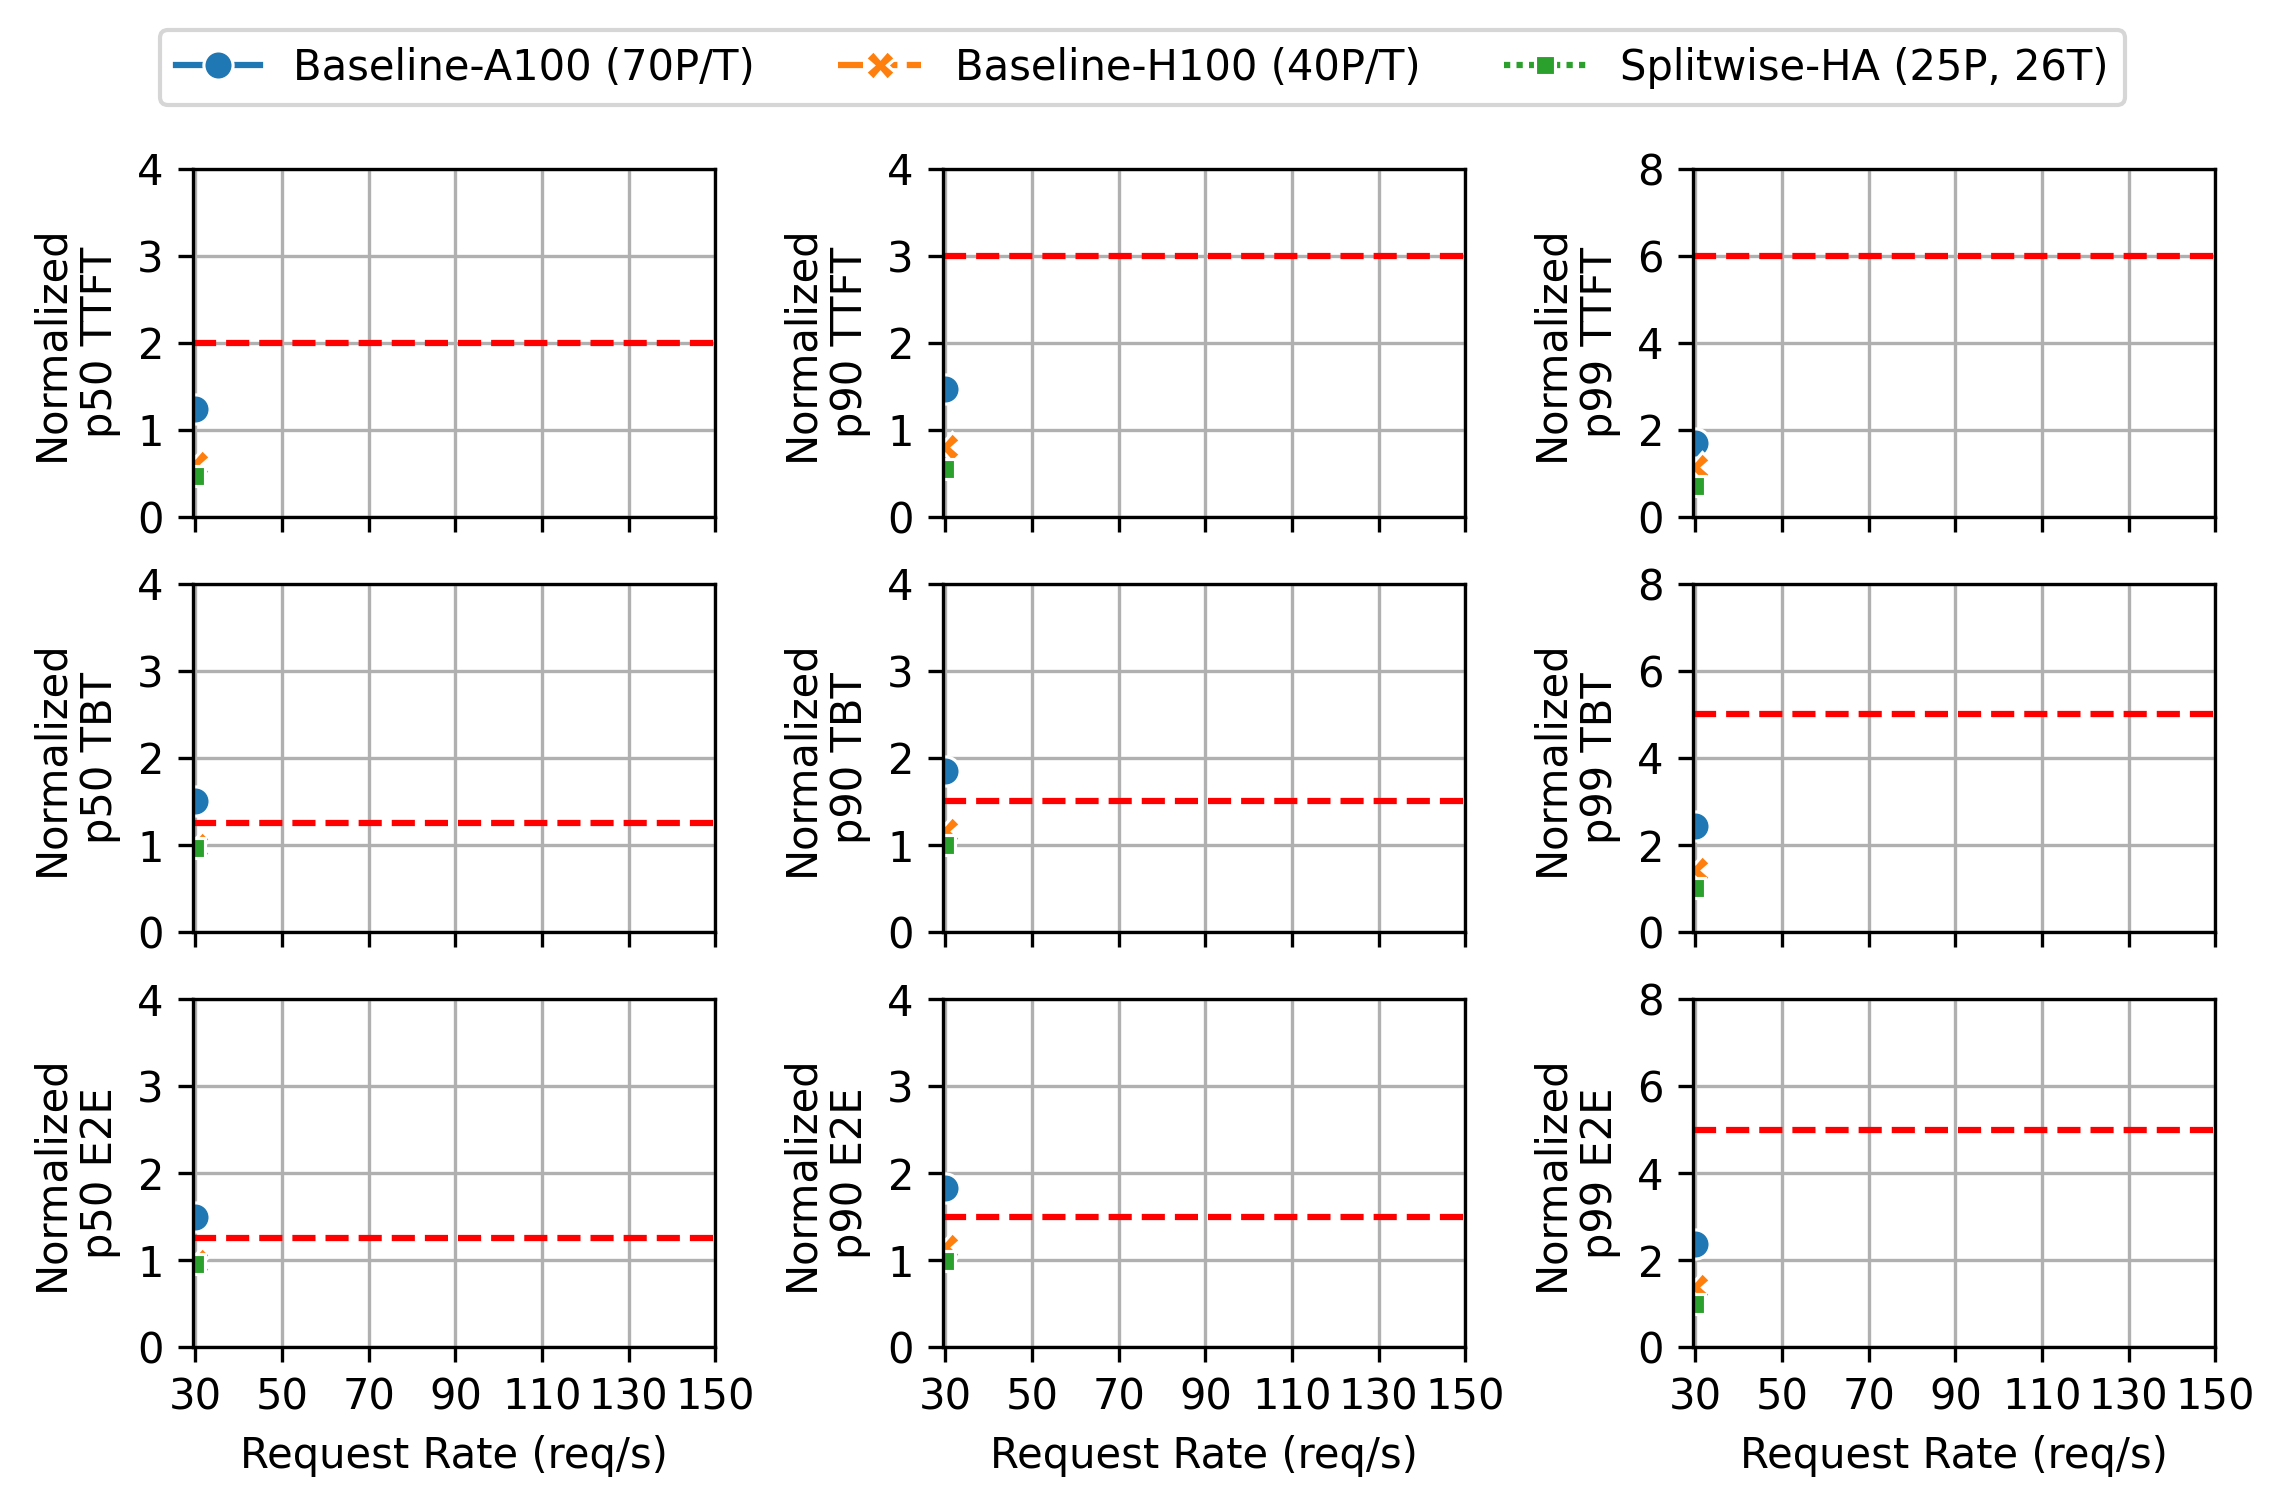

In [15]:
# isopower clusters, conv trace

isopower_conv_configs = [
    baseline_a100_config(70),
    baseline_h100_config(40),
    splitwise_aa_config(45, 25),
    splitwise_hh_config(25, 15),
    splitwise_ha_config(25, 26),
    splitwise_hhcap_config(25, 21),
]

min_x = 50
max_x = 181
if model_to_plot == "bloom-176b":
    min_x = 30
    max_x = 161
isopower_conv_traces = [f"rr_conv_{i}_1min" for i in range(80, 151, 10)]
isopower_conv_traces = [f"rr_conv_{i}" for i in range(min_x, max_x, 10)]

isopower_conv_results_df, isopower_conv_request_dfs = get_data(
    isopower_conv_configs, isopower_conv_traces, seed=seed, model=model_to_plot)
plot_y_vs_trace_new(isopower_conv_results_df,
                    isopower_conv_traces,
                    y_vars=["ttft_slowdown", "tbt_slowdown", "e2e_slowdown"],
                    #y_vars_labels=["TTFT\nSlowdown", "TBT\nSlowdown", "E2E\nSlowdown"],
                    title="")
                    #title="Isopower Clusters, Conversation Trace")
axs = plt.gca()
axs.set_xticks(ticks=range(0, len(isopower_conv_traces), 2), labels=[f"{i}" for i in range(min_x, max_x, 20)])
#plt.subplots_adjust(left=0.)
isopower_conv_results_df.to_csv(f"{plotsdata_dir}/isopower_conv_{model_to_plot}.csv", index=False)
plt.savefig(f"{plots_dir}/isopower_conv_{model_to_plot}.pdf", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# isopower clusters, code trace

isopower_code_configs = [
    baseline_a100_config(70),
    baseline_h100_config(40),
    splitwise_aa_config(55, 15),
    splitwise_hh_config(35, 5),
    splitwise_ha_config(35, 8),
    splitwise_hhcap_config(35, 7),
]

min_x = 50
max_x = 181
if model_to_plot == "bloom-176b":
    min_x = 30
    max_x = 101
isopower_code_traces = [f"rr_code_{i}_1min" for i in range(50, 121, 10)]
isopower_code_traces = [f"rr_code_{i}" for i in range(min_x, max_x, 10)]

isopower_code_results_df, isopower_code_request_dfs = get_data(
    isopower_code_configs, isopower_code_traces, seed=seed, model=model_to_plot)
plot_y_vs_trace_new(isopower_code_results_df,
                    isopower_code_traces,
                    y_vars=["ttft_slowdown", "tbt_slowdown", "e2e_slowdown"],
                    #y_vars_labels=["TTFT\nSlowdown", "TBT\nSlowdown", "E2E\nSlowdown"],
                    title="")
                    #title="Isopower Clusters, Code Trace")
isopower_code_results_df.to_csv(f"{plotsdata_dir}/isopower_code_{model_to_plot}.csv", index=False)
plt.savefig(f"{plots_dir}/isopower_code_{model_to_plot}.pdf", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# code cluster for conv trace

isopower_code_for_conv_results_df, isopower_code_for_conv_request_dfs = \
    get_data(isopower_code_configs, isopower_conv_traces, seed=seed, model=model_to_plot)
plot_y_vs_trace_new_swapped(isopower_code_for_conv_results_df,
                    isopower_conv_traces,
                    y_vars=["ttft_slowdown", "tbt_slowdown", "e2e_slowdown"],
                    quantiles=[0.9],
                    #y_vars_labels=["TTFT\nSlowdown", "TBT\nSlowdown", "E2E\nSlowdown"],
                    title="")
axs = plt.gca()
min_x = 50
max_x = 181
if model_to_plot == "bloom-176b":
    min_x = 30 
    max_x = 161
axs.set_xticks(ticks=range(0, len(isopower_conv_traces), 2), labels=[f"{i}" for i in range(30, max_x, 20)])
#plt.savefig(f"{plots_dir}/isopower_code_for_conv_{model_to_plot}.pdf", bbox_inches='tight')
isopower_code_for_conv_results_df.to_csv(f"{plotsdata_dir}/isopower_code_for_conv_{model_to_plot}_p90.csv", index=False)
plt.savefig(f"{plots_dir}/isopower_code_for_conv_{model_to_plot}_p90.pdf", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
find_max_throughput(find_within_slo(isopower_code_for_conv_results_df, slos))

In [ ]:
find_max_throughput(find_within_slo(isopower_conv_results_df, slos))

In [ ]:
# conv cluster for code trace

isopower_conv_for_code_results_df, isopower_conv_for_code_request_dfs = \
    get_data(isopower_conv_configs, isopower_code_traces, seed=seed, model=model_to_plot)
plot_y_vs_trace_new(isopower_conv_for_code_results_df,
                    isopower_code_traces,
                    y_vars=["ttft_slowdown", "tbt_slowdown", "e2e_slowdown"],
                    y_vars_labels=["TTFT\nSlowdown", "TBT\nSlowdown", "E2E\nSlowdown"],
                    title="Isopower Conversation Cluster, Code Trace")
max_x = 181
if model_to_plot == "bloom-176b":
    max_x = 141
isopower_conv_for_code_results_df.to_csv(f"{plotsdata_dir}/isopower_conv_for_code_{model_to_plot}.csv", index=False)
plt.savefig(f"{plots_dir}/isopower_conv_for_code_{model_to_plot}.pdf", bbox_inches='tight')
#axs.set_xticks(ticks=range(0, len(isopower_code_traces), 2), labels=[f"{i}" for i in range(50, max_x, 20)])
plt.show()
plt.close()

In [ ]:
find_max_throughput(find_within_slo(isopower_code_results_df, slos))[["name", "trace"]]

In [ ]:
find_max_throughput(find_within_slo(isopower_conv_for_code_results_df, slos))[["name", "trace"]]

In [ ]:
# isocost clusters, conv trace

isocost_conv_configs = [
    baseline_a100_config(86),
    baseline_h100_config(40),
    splitwise_aa_config(51, 35),
    splitwise_hh_config(25, 15),
    splitwise_ha_config(30, 21),
    splitwise_hhcap_config(30, 10),
]

max_x = 181
if model_to_plot == "bloom-176b":
    max_x = 171
isocost_conv_traces = [f"rr_conv_{i}_1min" for i in range(80, 151, 10)]
isocost_conv_traces = [f"rr_conv_{i}" for i in range(50, max_x, 10)]

isocost_conv_results_df, isocost_conv_request_dfs = get_data(
    isocost_conv_configs, isocost_conv_traces, seed=seed, model=model_to_plot)
plt.close()
plot_y_vs_trace_new(isocost_conv_results_df,
                    isocost_conv_traces,
                    y_vars=["ttft_slowdown", "tbt_slowdown", "e2e_slowdown"],
                    y_vars_labels=["TTFT\nSlowdown", "TBT\nSlowdown", "E2E\nSlowdown"],
                    title="Isocost Clusters, Conversation Trace")
axs = plt.gca()
axs.set_xticks(ticks=range(0, len(isocost_conv_traces), 2), labels=[f"{i}" for i in range(50, max_x, 20)])
isocost_conv_results_df.to_csv(f"{plotsdata_dir}/isocost_conv_{model_to_plot}.csv", index=False)
plt.savefig(f"{plots_dir}/isocost_conv_{model_to_plot}.pdf", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# isocost clusters, code trace

isocost_code_configs = [
    baseline_a100_config(86),
    baseline_h100_config(40),
    splitwise_aa_config(66, 20),
    splitwise_hh_config(35, 5),
    splitwise_ha_config(35, 10),
    splitwise_hhcap_config(35, 7),
]

max_x = 181
if model_to_plot == "bloom-176b":
    max_x = 121
isocost_code_traces = [f"rr_code_{i}_1min" for i in range(50, 121, 10)]
isocost_code_traces = [f"rr_code_{i}" for i in range(50, max_x, 10)]

isocost_code_results_df, isocost_code_request_dfs = get_data(
    isocost_code_configs, isocost_code_traces, seed=seed, model=model_to_plot)
plot_y_vs_trace_new(isocost_code_results_df,
                    isocost_code_traces,
                    y_vars=["ttft_slowdown", "tbt_slowdown", "e2e_slowdown"],
                    y_vars_labels=["TTFT\nSlowdown", "TBT\nSlowdown", "E2E\nSlowdown"],
                    title="Isocost Clusters, Code Trace")
isocost_code_results_df.to_csv(f"{plotsdata_dir}/isocost_code_{model_to_plot}.csv", index=False)
plt.savefig(f"{plots_dir}/isocost_code_{model_to_plot}.pdf", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# cost and max.throughput for isopower configurations

plot_cost_throughput_optimal_within_slo(isopower_conv_results_df, "Baseline-A100", slos)
isopower_conv_results_df.to_csv(f"{plotsdata_dir}/isopower_conv_cost_throughput_{model_to_plot}.csv", index=False)
plt.savefig(f"{plots_dir}/isopower_conv_cost_throughput_{model_to_plot}.pdf", bbox_inches='tight')
plt.show()
plt.close()

plot_cost_throughput_optimal_within_slo(isopower_code_results_df, "Baseline-A100", slos)
isopower_code_results_df.to_csv(f"{plotsdata_dir}/isopower_code_cost_throughput_{model_to_plot}.csv", index=False)
plt.savefig(f"{plots_dir}/isopower_code_cost_throughput_{model_to_plot}.pdf", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# power and max. throughput for isopower configurations

plot_power_throughput_optimal_within_slo(isocost_conv_results_df, "Baseline-A100", slos)
isocost_conv_results_df.to_csv(f"{plotsdata_dir}/isocost_conv_power_throughput_{model_to_plot}.csv", index=False)
plt.savefig(f"{plots_dir}/isocost_conv_power_throughput_{model_to_plot}.pdf", bbox_inches='tight')
plt.show()
plt.close()

plot_power_throughput_optimal_within_slo(isocost_code_results_df, "Baseline-A100", slos)
isocost_code_results_df.to_csv(f"{plotsdata_dir}/isocost_code_power_throughput_{model_to_plot}.csv", index=False)
plt.savefig(f"{plots_dir}/isocost_code_power_throughput_{model_to_plot}.pdf", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# provisioning sweep

configs = []

min_a100 = 1
max_a100 = 70
min_h100 = 1
max_h100 = 40

for num_a100 in range(min_a100, 2*max_a100, 1):
    configs.append(baseline_a100_config(num_a100))

for num_h100 in range(min_h100, 2*max_h100, 1):
    configs.append(baseline_h100_config(num_h100))

for num_prompts in range(min_a100, max_a100, 1):
    for num_tokens in range(min_a100, max_a100, 1):
        configs.append(splitwise_aa_config(num_prompts, num_tokens))

for num_prompts in range(min_h100, max_h100, 1):
    for num_tokens in range(min_h100, max_h100, 1):
        configs.append(splitwise_hh_config(num_prompts, num_tokens))

for num_prompts in range(min_h100, max_h100, 1):
    for num_tokens in range(min_a100, max_a100, 1):
        configs.append(splitwise_ha_config(num_prompts, num_tokens))

for num_prompts in range(min_h100, max_h100, 1):
    for num_tokens in range(min_h100, max_h100, 1):
        configs.append(splitwise_hhcap_config(num_prompts, num_tokens))

provision_code_trace = ["rr_code_70_2min"]
#provision_conv_trace = ["rr_conv_70_2min"]

provision_code_df, provision_code_request_dfs = get_data(configs, traces=provision_code_trace, seed=seed, model=model_to_plot)
#provision_conv_df, provision_conv_request_dfs = get_data(configs, traces=provision_conv_trace, seed=seed, model=model_to_plot)

In [ ]:
def plot_provision_sweep(result_df):
    subset_df = result_df

    # plot scatter of num_prompts vs num_tokens for the ttft times
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 7), constrained_layout=True)

    title_dict = {
        "ttft_slowdown": "TTFT Slowdown",
        "tbt_slowdown": "TBT Slowdown",
        "e2e_slowdown": "E2E Slowdown"
    }

    y_vars = ["ttft_slowdown", "tbt_slowdown", "e2e_slowdown"]
    quantiles = [0.5, 0.9, 0.99]

    cmap = plt.get_cmap('viridis_r')
    colors = cmap(np.arange(cmap.N))

    max_slowdown = max(subset_df["ttft_slowdown_p99"].max(), subset_df["tbt_slowdown_p99"].max(), subset_df["e2e_slowdown_p99"].max())
    max_slo = 6
    colors[-1] = [0, 0, 0, 1]  # RGBA for black
    new_cmap = mcolors.ListedColormap(colors)

    all_slo_df = subset_df
    for y_var in y_vars:
        for quantile in quantiles:
            all_slo_df = all_slo_df[all_slo_df[f"{y_var}_p{int(quantile * 100)}"] <= get_slo(y_var, quantile)]

    for y_var in y_vars:
        for quantile in quantiles:
            sc = axs[y_vars.index(y_var)][quantiles.index(quantile)].scatter(
                subset_df["num_prompts"],
                subset_df["num_tokens"],
                c=subset_df[f"{y_var}_p{int(quantile * 100)}"],
                #norm=mcolors.LogNorm(vmin=1, vmax=max_slo),
                norm=mcolors.Normalize(vmin=1, vmax=max_slo),
                cmap=new_cmap
                #cmap='viridis_r'
            )
            axs[y_vars.index(y_var)][quantiles.index(quantile)].set_xlabel("# Prompt Machines")
            axs[y_vars.index(y_var)][quantiles.index(quantile)].set_ylabel("# Token Machines")
            axs[y_vars.index(y_var)][quantiles.index(quantile)].set_title(f"p{int(quantile * 100)} {title_dict[y_var]}")
            #axs[y_vars.index(y_var)][quantiles.index(quantile)].legend(bbox_to_anchor=(0.5, 1.11), loc="lower center", ncol=3, fontsize=7)
            axs[y_vars.index(y_var)][quantiles.index(quantile)].grid()
            
            slo = get_slo(y_var, quantile)
            # Filter the DataFrame to only include rows that meet the SLO
            slo_df = subset_df[subset_df[f"{y_var}_p{int(quantile * 100)}"] <= slo]

            # Group by 'num_prompts' and find the minimum 'num_tokens' for each group
            frontier_df = slo_df.groupby('num_prompts')['num_tokens'].min().reset_index()

            # Plot the frontier points
            axs[y_vars.index(y_var)][quantiles.index(quantile)].scatter(
                frontier_df["num_prompts"],
                frontier_df["num_tokens"],
                c='red',  # Color of the frontier points
                label='SLO Frontier'
            )

            # Find the cost optimal and power optimal points that meet the SLO
            #cost_optimal_point = slo_df.loc[slo_df['cost'].idxmin()]
            #power_optimal_point = slo_df.loc[slo_df['power'].idxmin()]
            cost_optimal_point = all_slo_df.loc[all_slo_df['cost'].idxmin()]
            power_optimal_point = all_slo_df.loc[all_slo_df['power'].idxmin()]

            # Plot the cost optimal point
            axs[y_vars.index(y_var)][quantiles.index(quantile)].scatter(
                cost_optimal_point["num_prompts"],
                cost_optimal_point["num_tokens"],
                c='azure',  # Color of the cost optimal point
                s=120,
                label='Cost Optimal',
                marker='*',
                edgecolors='black',
            )

            # Plot the power optimal point
            #axs[y_vars.index(y_var)][quantiles.index(quantile)].scatter(
            #    power_optimal_point["num_prompts"],
            #    power_optimal_point["num_tokens"],
            #    c='green',  # Color of the power optimal point
            #    label='Power Optimal'
            #)

            #axs[y_vars.index(y_var)][quantiles.index(quantile)].legend()

            # add colorbar
            #plt.colorbar(sc, ax=axs[y_vars.index(y_var)][quantiles.index(quantile)])
            # add colorbar with custom tick labels
            cbar = plt.colorbar(sc, ax=axs[y_vars.index(y_var)][quantiles.index(quantile)])
            tick_locs = list(cbar.get_ticks())
            #tick_locs.append(slo)
            cbar.set_ticks(tick_locs)
            tick_labels = [str(int(tick)) if tick < max_slo else f'{max_slo}+' for tick in tick_locs]
            #tick_labels[-1] = 'SLO'
            cbar.set_ticklabels(tick_labels)
            cbar.ax.axhline(get_slo(y_var, quantile), color='red', linewidth=3)

            # Add SLO label to the left of the colorbar
            cbar.set_label('SLO', rotation=0, labelpad=0, color='red')
            slo_position = (slo - 1) / (max_slo - 1)
            cbar.ax.yaxis.set_label_coords(-1.7, slo_position + 0.05)
    print(cost_optimal_point["num_prompts"], cost_optimal_point["num_tokens"])


In [ ]:
plot_provision_sweep(provision_code_df[provision_code_df["system"] == "Splitwise-HH"])
plt.savefig(f"{plots_dir}/hh_provision_code_sweep_{model_to_plot}.pdf", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
provision_code_df.to_csv(f"{plotsdata_dir}/provision_code_sweep_{model_to_plot}.csv", index=False)
provision_conv_df.to_csv(f"{plotsdata_dir}/provision_conv_sweep_{model_to_plot}.csv", index=False)

In [ ]:
isothroughput_code_cost_df = plot_isothroughput_cost_optimal_within_slo(provision_code_df, "Baseline-A100", slos)
isothroughput_code_cost_df.to_csv(f"{plotsdata_dir}/isothroughput_code_cost_{model_to_plot}.csv", index=False)
plt.savefig(f"{plots_dir}/isothroughput_code_cost_{model_to_plot}.pdf", bbox_inches='tight')
plt.show()
plt.close()

isothroughput_code_power_df = plot_isothroughput_power_optimal_within_slo(provision_code_df, "Baseline-A100", slos)
isothroughput_code_power_df.to_csv(f"{plotsdata_dir}/isothroughput_code_power_{model_to_plot}.csv", index=False)
plt.savefig(f"{plots_dir}/isothroughput_code_power_{model_to_plot}.pdf", bbox_inches='tight')
plt.show()
plt.close()

isothroughout_code_count_df = plot_isothroughput_count_optimal_within_slo(provision_code_df, "Baseline-A100", slos)
isothroughout_code_count_df.to_csv(f"{plotsdata_dir}/isothroughput_code_count_{model_to_plot}.csv", index=False)
plt.savefig(f"{plots_dir}/isothroughput_code_count_{model_to_plot}.pdf", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
isothroughput_conv_cost_df = plot_isothroughput_cost_optimal_within_slo(provision_conv_df, "Baseline-A100", slos)
isothroughput_conv_cost_df.to_csv(f"{plotsdata_dir}/isothroughput_conv_cost_{model_to_plot}.csv")
plt.savefig(f"{plots_dir}/isothroughput_conv_cost_{model_to_plot}.pdf", bbox_inches='tight')
plt.show()
plt.close()

isothroughput_conv_power_df = plot_isothroughput_power_optimal_within_slo(provision_conv_df, "Baseline-A100", slos)
isothroughput_conv_power_df.to_csv(f"{plotsdata_dir}/isothroughput_conv_power_{model_to_plot}.csv")
plt.savefig(f"{plots_dir}/isothroughput_conv_power_{model_to_plot}.pdf", bbox_inches='tight')
plt.show()
plt.close()

isothroughput_conv_count_df = plot_isothroughput_count_optimal_within_slo(provision_conv_df, "Baseline-A100", slos)
isothroughput_conv_count_df.to_csv(f"{plotsdata_dir}/isothroughput_conv_count_{model_to_plot}.csv")
plt.savefig(f"{plots_dir}/isothroughput_conv_count_{model_to_plot}.pdf", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
find_least_count(find_within_slo(provision_conv_df, slos)).drop_duplicates(subset=["system"])

In [ ]:
find_least_power(find_within_slo(provision_code_df, slos))

In [ ]:
def find_throughput(request_nodes_df, t_start=60, t_end=540):
    """
    Finds the throughput of a request_df between t_start and t_end
    """
    return request_nodes_df[
            (request_nodes_df["node_type"] == "TOKEN") & \
            (request_nodes_df["completion_timestamp"] >= t_start) & \
            (request_nodes_df["completion_timestamp"] < t_end)]["request_id"].nunique() / (t_end - t_start)

In [ ]:
for config in isocost_conv_configs:
    request_nodes_df = get_request_nodes_with_config(results_dir, config, "rr_conv_180", seed=0, model=model_to_plot)
    throughput = find_throughput(request_nodes_df)
    print(f"{config['name']}: {throughput} rps, ${round(config['cost'], 2)}, {round(throughput/config['cost'], 2)} rps/$")


In [ ]:
configs_within_slo = find_within_slo(provision_code_df, slos)
cheapest_configs = find_cheapest(configs_within_slo)
least_power_configs = find_least_power(configs_within_slo)

In [ ]:
def plot_num_batch_tokens(config, trace, seed, model=""):
    df = get_instances_data_with_config(results_dir, config, trace, seed, model)
    if "splitwise" in config.get("start_state", ""):
        num_prompt_batch_tokens, num_token_batch_tokens = get_num_batch_tokens_splitwise(df)
        sns.ecdfplot(num_prompt_batch_tokens, label="Prompt")
        sns.ecdfplot(num_token_batch_tokens, label="Token")
    else:
        num_batch_tokens = get_num_batch_tokens(df)
        sns.ecdfplot(num_batch_tokens, label="Batch")
    plt.xlabel("Number of Batch Tokens")
    plt.ylabel("CDF")
    plt.legend()
    plt.title(f'{config["name"]} {config["scheduler"]}, {trace}')
    plt.grid()
    return df

In [ ]:
def plot_duration_ccdf_batch_tokens(config, trace, seed, model=""):
    df = get_instances_data_with_config(results_dir, config, trace, seed, model)
    grouped_df = df[["batch_tokens", "duration"]].groupby("batch_tokens").sum()

    # find idle durations between iteration_end and iteration_start of next row in df for each instance identified by name
    total_idle_duration = 0
    for name in df["name"].unique():
        inst_df = df[df["name"] == name].sort_values("iteration_start")
        inst_df["idle_duration"] = inst_df["iteration_start"] - inst_df["iteration_end"].shift(1)
        inst_df["idle_duration"] = inst_df["idle_duration"].fillna(0)
        total_idle_duration += inst_df["idle_duration"].sum()

    # add entry to grouped_df at index 0
    grouped_df.loc[0] = [total_idle_duration]

    # sortby grouped_df.index
    grouped_df = grouped_df.sort_index()
    grouped_df["cum_duration"] = np.cumsum(grouped_df["duration"])
    grouped_df["cum_duration"] /= grouped_df["cum_duration"].max()
    # plot cumulative cdf of duration vs number of batch tokens
    #plt.plot(grouped_df.index, np.cumsum(grouped_df["duration"]))
    plt.plot(grouped_df.index, grouped_df["cum_duration"])
    plt.xlabel("Number of Batch Tokens")
    plt.ylabel("Cumulative Duration (s)")
    plt.grid()
    plt.title(f'{config["name"]} {config["scheduler"]}, {trace}')

    #if "splitwise" in config.get("start_state", ""):
    #    n_prompt = int(config["start_state"].split("_")[1])
    #    num_prompt_batch_tokens, num_token_batch_tokens = get_num_batch_tokens_splitwise(df, n_prompt)
    #    sns.ecdfplot(num_prompt_batch_tokens, label="Prompt")
    #    sns.ecdfplot(num_token_batch_tokens, label="Token")
    #else:
    #    num_batch_tokens = get_num_batch_tokens(df)
    #    sns.ecdfplot(num_batch_tokens, label="Batch")
    #plt.xlabel("Number of Batch Tokens")
    #plt.ylabel("CDF")
    #plt.legend()
    #plt.grid()
    #return df   

In [ ]:
def find_idle_duration(df):
    total_idle_duration = 0
    for name in df["name"].unique():
        inst_df = df[df["name"] == name].sort_values("iteration_start")
        inst_df["idle_duration"] = inst_df["iteration_start"] - inst_df["iteration_end"].shift(1)
        inst_df["idle_duration"] = inst_df["idle_duration"].fillna(0)
        total_idle_duration += inst_df["idle_duration"].sum()
    return total_idle_duration

def compare_duration_ccdf_batch_tokens(baseline_config, splitwise_config, trace, seed, model=""):
    baseline_df = get_instances_data_with_config(results_dir, baseline_config, trace, seed, model)
    splitwise_df = get_instances_data_with_config(results_dir, splitwise_config, trace, seed, model)

    # for baseline
    # find idle durations between iteration_end and iteration_start of next row in df for each instance identified by name
    baseline_idle_duration = find_idle_duration(baseline_df)
    # add entry to grouped df at index 0
    grouped_baseline_df = baseline_df[["batch_tokens", "duration"]].groupby("batch_tokens").sum()
    grouped_baseline_df.loc[0] = [baseline_idle_duration]

    # for splitwise, separate into prompt and token servers, and repeat the same process
    # find idle durations between iteration_end and iteration_start of next row in df for each instance identified by name
    splitwise_prompt_df = splitwise_df[splitwise_df["tag"] == "prompt"]
    splitwise_token_df = splitwise_df[splitwise_df["tag"] == "token"]
    splitwise_prompt_idle_duration = find_idle_duration(splitwise_prompt_df)
    splitwise_token_idle_duration = find_idle_duration(splitwise_token_df)
    # add entry to grouped df at index 0
    grouped_splitwise_prompt_df = splitwise_prompt_df[["batch_tokens", "duration"]].groupby("batch_tokens").sum()
    grouped_splitwise_prompt_df.loc[0] = [splitwise_prompt_idle_duration]
    grouped_splitwise_token_df = splitwise_token_df[["batch_tokens", "duration"]].groupby("batch_tokens").sum()
    grouped_splitwise_token_df.loc[0] = [splitwise_token_idle_duration]

    # sortby grouped_df.index
    grouped_baseline_df = grouped_baseline_df.sort_index()
    grouped_baseline_df["cum_duration"] = np.cumsum(grouped_baseline_df["duration"])
    grouped_baseline_df["cum_duration"] /= grouped_baseline_df["cum_duration"].max()

    grouped_splitwise_prompt_df = grouped_splitwise_prompt_df.sort_index()
    grouped_splitwise_prompt_df["cum_duration"] = np.cumsum(grouped_splitwise_prompt_df["duration"])
    grouped_splitwise_prompt_df["cum_duration"] /= grouped_splitwise_prompt_df["cum_duration"].max()
    
    grouped_splitwise_token_df = grouped_splitwise_token_df.sort_index()
    grouped_splitwise_token_df["cum_duration"] = np.cumsum(grouped_splitwise_token_df["duration"])
    grouped_splitwise_token_df["cum_duration"] /= grouped_splitwise_token_df["cum_duration"].max()

    fig, axs = plt.subplots(1, 1, figsize=(3, 3), constrained_layout=True)

    # plot cumulative cdf of duration vs number of batch tokens
    #plt.plot(grouped_df.index, np.cumsum(grouped_df["duration"]))
    axs.plot(grouped_baseline_df.index, grouped_baseline_df["cum_duration"], label="Baseline-H100")
    axs.plot(grouped_splitwise_prompt_df.index, grouped_splitwise_prompt_df["cum_duration"], label="Splitwise-HH (Prompt)")
    axs.plot(grouped_splitwise_token_df.index, grouped_splitwise_token_df["cum_duration"], label="Splitwise-HH (Token)")

    axs.set_xlabel("Number of Batch Tokens")
    axs.set_ylabel("Cumulative Duration")
    axs.grid()
    axs.set_xscale("log")
    axs.legend(loc="lower center", ncol=1, bbox_to_anchor=(0.5, 1.0))
    #ax.title(f'{config["name"]} {config["scheduler"]}, {trace}')
    
    # return dataframe
    return baseline_df, splitwise_df

    #if "splitwise" in config.get("start_state", ""):
    #    n_prompt = int(config["start_state"].split("_")[1])
    #    num_prompt_batch_tokens, num_token_batch_tokens = get_num_batch_tokens_splitwise(df, n_prompt)
    #    sns.ecdfplot(num_prompt_batch_tokens, label="Prompt")
    #    sns.ecdfplot(num_token_batch_tokens, label="Token")
    #else:
    #    num_batch_tokens = get_num_batch_tokens(df)
    #    sns.ecdfplot(num_batch_tokens, label="Batch")
    #plt.xlabel("Number of Batch Tokens")
    #plt.ylabel("CDF")
    #plt.legend()
    #plt.grid()
    #return df   

In [ ]:
baseline_df, splitwise_df = compare_duration_ccdf_batch_tokens(
    baseline_h100_config(40),
    splitwise_hh_config(25, 15),
    #"rr_conv_70",
    "rr_conv_130",
    seed=0,
    model=model_to_plot)
baseline_df.to_csv(os.path.join(plotsdata_dir, f"duration_ccdf_batch_tokens_baseline_{model_to_plot}_conv130.csv"))
splitwise_df.to_csv(os.path.join(plotsdata_dir, f"duration_ccdf_batch_tokens_splitwise_{model_to_plot}_conv130.csv"))
#plt.savefig(os.path.join(plots_dir, f"duration_ccdf_batch_tokens_{model_to_plot}_conv70.pdf"))
plt.savefig(os.path.join(plots_dir, f"duration_ccdf_batch_tokens_{model_to_plot}_conv130.pdf"))
plt.show()
plt.close()

In [ ]:
def plot_sweep(results_df, title=None, x="num_prompts"):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(6, 4), sharex=True, constrained_layout=True)
    sns.lineplot(data=results_df, x=x, y="ttft_slowdown_p90", style="system", markers=True, markersize=7, ax=axs[0][0])
    sns.lineplot(data=results_df, x=x, y="tbt_slowdown_p90", style="system", markers=True, markersize=7, ax=axs[1][0])
    sns.lineplot(data=results_df, x=x, y="e2e_slowdown_p90", style="system", markers=True, markersize=7, ax=axs[2][0])
    sns.lineplot(data=results_df, x=x, y="ttft_slowdown_p50", style="system", markers=True, markersize=7, ax=axs[0][1])
    sns.lineplot(data=results_df, x=x, y="tbt_slowdown_p50", style="system", markers=True, markersize=7, ax=axs[1][1])
    sns.lineplot(data=results_df, x=x, y="e2e_slowdown_p50", style="system", markers=True, markersize=7, ax=axs[2][1])

    for ax in axs.flatten():
        ax.grid()
        ax.set_xlabel(f"{x} servers")

    #sns.move_legend(axs[0][0], "lower center", bbox_to_anchor=(0.5, 1.05), ncol=2, title="")
    axs[0][0].get_legend().set_visible(False)
    axs[1][0].get_legend().set_visible(False)
    axs[2][0].get_legend().set_visible(False)
    axs[0][1].get_legend().set_visible(False)
    axs[1][1].get_legend().set_visible(False)
    axs[2][1].get_legend().set_visible(False)

    # create a single legend in center of figure
    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3, title="", bbox_to_anchor=(0.5, 1.01))

    #axs[0][0].set_yscale("log")
    #axs[0][1].set_yscale("log")
    #axs[2][0].set_yscale("log")
    #axs[2][1].set_yscale("log")
    #axs[0][0].set_ylim(bottom=0, top=2)
    #axs[0][1].set_ylim(bottom=0, top=2)

    # set same y axis limits for plots in the same row (same as 0th column)
    #axs[0][1].set_ylim(axs[0][0].get_ylim())
    #axs[1][1].set_ylim(axs[1][0].get_ylim())
    #axs[2][1].set_ylim(axs[2][0].get_ylim())


    axs[0][0].set_ylabel("p90 TTFT (s)")
    axs[1][0].set_ylabel("p90 TBT (s)")
    #axs[2][0].set_ylabel("p99 Nth Token (s)")
    axs[2][0].set_ylabel("p90 e2e (s)")
    axs[0][1].set_ylabel("p50 TTFT (s)")
    axs[1][1].set_ylabel("p50 TBT (s)")
    axs[2][1].set_ylabel("p50 e2e (s)")
    #axs[2][1].set_ylabel("p50 Nth Token (s)")

    if title:
        fig.suptitle(title, fontsize=12)

    # set 300dpi
    plt.gcf().set_dpi(300)

    plt.show()
    plt.close()


In [ ]:
# isopower sweeps

configs = []

max_h100 = 40
for num_h100 in range(5, max_h100, 5):
    #num_a100 = int(10200 * (max_h100 - num_h100) // 6500)
    num_a100 = int(44 * (max_h100 - num_h100) // 24.8)
    configs.append(splitwise_ha_config(num_h100, num_a100))

for num_h100 in range(5, max_h100, 5):
    num_prompts = num_h100
    num_tokens = max_h100 - num_prompts
    configs.append(splitwise_hh_config(num_prompts, num_tokens))
    configs.append(splitwise_hhcap_config(num_prompts, num_tokens))

max_a100 = 70
for num_prompts in range(5, max_a100, 5):
    num_tokens = max_a100 - num_prompts
    configs.append(splitwise_aa_config(num_prompts, num_tokens))

#traces = ["rr_conv_70"]
traces = ["rr_code_100"]

results_df, request_dfs = get_data(configs, traces, seed=seed, model=model_to_plot)
plot_sweep(results_df, title=f"Isopower sweeps, {traces[0]}")

In [16]:
# isocost sweeps

configs = []

max_h100 = 40
for num_h100 in range(5, max_h100, 5):
    #num_a100 = int(10200 * (max_h100 - num_h100) // 6500)
    num_a100 = int(4.76 * (max_h100 - num_h100) // 2.21)
    configs.append(splitwise_ha_config(num_h100, num_a100))

for num_h100 in range(5, max_h100, 5):
    num_prompts = num_h100
    num_tokens = max_h100 - num_prompts
    configs.append(splitwise_hh_config(num_prompts, num_tokens))

max_a100 = 86
for num_tokens in range(5, max_a100, 5):
    num_prompts = max_a100 - num_tokens
    configs.append(splitwise_aa_config(num_prompts, num_tokens))

#traces = ["rr_conv_70"]
traces = ["rr_code_90"]

results_df, request_dfs = get_data(configs, traces, seed=seed, model=model_to_plot)
plot_sweep(results_df, title=f"Isocost sweeps, {traces[0]}")

[Errno 2] No such file or directory: '../results/0/splitwise_1_1/rr_code_90/75_5/bloom-176b/mixed_pool/summary.csv'
Failed to read ../results/0/splitwise_1_1/rr_code_90/75_5/bloom-176b/mixed_pool/summary.csv
Failed to read ../results/0/splitwise_1_1/rr_code_90/75_5/bloom-176b/mixed_pool/detailed/0.csv
[Errno 2] No such file or directory: '../results/0/splitwise_1_1/rr_code_90/64_10/bloom-176b/mixed_pool/summary.csv'
Failed to read ../results/0/splitwise_1_1/rr_code_90/64_10/bloom-176b/mixed_pool/summary.csv
Failed to read ../results/0/splitwise_1_1/rr_code_90/64_10/bloom-176b/mixed_pool/detailed/0.csv
[Errno 2] No such file or directory: '../results/0/splitwise_1_1/rr_code_90/53_15/bloom-176b/mixed_pool/summary.csv'
Failed to read ../results/0/splitwise_1_1/rr_code_90/53_15/bloom-176b/mixed_pool/summary.csv
Failed to read ../results/0/splitwise_1_1/rr_code_90/53_15/bloom-176b/mixed_pool/detailed/0.csv
[Errno 2] No such file or directory: '../results/0/splitwise_1_1/rr_code_90/43_20/blo

NameError: name 'plot_sweep' is not defined